**Author:** **Ritesh** **Chowdhry**
## **Description**: 
In this notebook I have created a CNN Model for training Fashion_MNIST dataset. The dataset has been imported from datasets module in torchvision pytorch.  
 
### Second cell:
*   In the second cell I have written all the utility functions, model and training function. 
*   The training function also has the code for plotting loss and accuracy plots and early stopping (which requires validation == True in training function so, validation set is required for that).

Source of early stopping algorithm used: https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

Contact me @ riteshchoudhery313@gmail.com to discuss anything about this notebook.
---

 





 
  


In [ ]:
#Importing the libraries

import pandas as pd
import numpy as np
import shutil
import os

# Pytorch modules used in my code.

import torch

from torch import nn
from torch.utils.data import DataLoader

from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Conv2d

from torchvision import transforms
from torchvision import datasets

# These modules are which I've used for results visulaization.
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import time

# This is just for interfacing the training progress.
from tqdm.autonotebook import tqdm
from google.colab import files
try:
  import wandb
except:
  # WandB – Install the W&B library
  !pip install wandb -q
  import wandb


#Source: https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
try:
  from pytorchtools import EarlyStopping
except:
  !git clone https://github.com/Bjarten/early-stopping-pytorch.git
  shutil.move("/content/early-stopping-pytorch/pytorchtools.py","/content/pytorchtools.py")
  from pytorchtools import EarlyStopping

In [14]:
# This cell has all the utility functions, model and training function.

# CNN_model used in this notebook.
class network(nn.Module):
  def __init__(self,dropout_flag,layers):
    super(network, self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
    if(layers==2):
      self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2))
    elif(layers==3):
      self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2))
      self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),nn.ReLU())
    if(dropout_flag == True):
      self.drop_out = nn.Dropout(p=0.6)
    if(layers==2):
      self.fc1 = nn.Linear(7 * 7 * 64, 1000)
    elif(layers==3):
      self.fc1 = nn.Linear(7 * 7 * 128, 1000)
    else:
      self.fc1 = nn.Linear(14 * 14 * 32, 1000)
    self.fc2 = nn.Linear(1000, 10)
  def forward(self, x):
    x = self.layer1(x)
    if(layers==2):
      x = self.layer2(x)
    elif(layers==3):
      x = self.layer2(x)
      x = self.layer3(x)
    x = x.reshape(x.size(0), -1)
    if(dropout_flag == True):
      x = self.drop_out(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

# Train the model
def training(train_dataloader, model, learning_rate, num_epochs, patience_for_early_stopping, start_time = 0.0,loss_function = "Cross Entropy",optimizer_choice = "SGD",name_run_wandb = "random_run",
             wandb_log_status = True, validation = False, validation_loader = None, plots = False, early_stopping_enabler = False, download_plots = False):

  log_train_loss = []
  log_train_accuracy = []
  log_valid_loss = []
  log_valid_accuracy = []
  epoch_plot_values = []
  if torch.cuda.is_available():
    device_available = torch.device("cuda")  
  else: 
      device_available = torch.device("cpu")
  print(device_available)

  # initialize the early_stopping object
  if(validation == True):
    early_stopping = EarlyStopping(patience=patience_for_early_stopping, verbose=True)

  onehot_encoder = OneHotEncoder(sparse=False)
  # Loss and optimizer
  if(loss_function == "Cross Entropy"):
    criterion = nn.CrossEntropyLoss()
  elif(loss_function == "MSE"):
    criterion = nn.MSELoss()
  
  if(optimizer_choice == "SGD"):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=learning_rate/4)
  elif(optimizer_choice == "adam"):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  model.train()
  
  try:
    if(wandb_log_status == True):
      wandb.watch(model, log="all")
  except:  
    pass

  for epoch in range(num_epochs):
    train_mean_loss = 0
    train_mean_acc = 0
    rand_var = 0

    temp_print = 0
    
    for i, (train_images, train_label) in enumerate(train_dataloader):
      model.train()
      """
      rand_var += 1
      if(rand_var == 10):
        break
      """
      # Run the forward pass
      train_images = train_images.to(device_available)
      train_label = train_label.to(device_available)
      train_output = model(train_images)
      loss = criterion(train_output, train_label)
      train_mean_loss +=loss.item()

      train_acc = calc_accuracy(train_output,train_label)
      train_mean_acc += train_acc 
      temp_print += 1
      # if(temp_print%20==0):
      #   print("Accuracy for batch: ", train_acc)
      
      # Backprop and perform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if(validation == True):
        model.eval()
        with torch.no_grad():
          valid_mean_loss = 0
          valid_mean_acc = 0
          for valid_input,valid_label in validation_loader:
            valid_input = valid_input.to(device_available)
            valid_label = valid_label.to(device_available)
            valid_output = model(valid_input)
            valid_loss = criterion(valid_output,valid_label)
            valid_acc = calc_accuracy(valid_output,valid_label)
            valid_mean_acc += valid_acc
            valid_mean_loss += valid_loss.item() 

    log_train_loss.append((train_mean_loss/len(train_dataloader)))
    log_train_accuracy.append((train_mean_acc/len(train_dataloader)))
    if(validation == True):
      log_valid_loss.append((valid_mean_loss/len(validation_loader)))
      log_valid_accuracy.append((valid_mean_acc/len(validation_loader)))

    epoch_plot_values.append(epoch)
    
    print("Epoch:",epoch)
    print("Training Loss:",(train_mean_loss/len(train_dataloader)))
    print("Training accuracy:", (train_mean_acc/len(train_dataloader)), "%")
    if(wandb_log_status == True):
      wandb.log({"Train Accuracy": (train_mean_acc/len(train_dataloader)), "Train Loss": (train_mean_loss/len(train_dataloader))})

    if(validation == True):
      print("Validation loss:", valid_mean_loss/len(validation_loader))
      print("Valdation Accuracy:", valid_mean_acc/len(validation_loader),"%")
      if(wandb_log_status == True):
        wandb.log({"Valid Accuracy": (valid_mean_acc/len(validation_loader)), "Valid Loss": (valid_mean_loss/len(validation_loader))})

    print("*******************************************************")


    ############################ Early_stopping_condtion ############
    if(validation == True and early_stopping_enabler == True): 
      early_stopping((valid_mean_loss/len(validation_loader)), model)
        
      if early_stopping.early_stop:
          print("Early stopping")
          num_epochs = epoch
          break

      # if((valid_mean_acc/len(validation_loader)) == 100):
      #   print("Validation accuracy reached 100%, stopping early.")
      #   break
      # elif(len(log_valid_loss)>20):
      #   if(log_valid_loss[-20]<(sum(log_valid_loss[-20:])/20)):
      #     print(sum(log_valid_loss[-20:])/20)
      #     print("Validation loss started to increase, stopping early.")
      #     break

  if(plots == True):

    end_time = time.time()
    plot_x_limit = num_epochs - (1+num_epochs/10)
    # plot_x_limit = num_epochs 
    learning_rate_str = "Learning rate: " + str(learning_rate)
    loss_str = "Loss: " + str(loss_function)
    optimizer_str = "Optimizer: " + str(optimizer_choice)
    time_elapsed = "Training Time: "+str(round((end_time - start_time)/60,2)) + " min"

    ax1, ax2 = plot_function(epoch_plot_values,log_train_accuracy, log_train_loss, log_valid_loss, log_valid_accuracy, plot_x_limit, learning_rate_str, loss_str, optimizer_str, time_elapsed, validation)
    plt.show()

    train_loss_plot_name_run = "loss_plot"+ name_run_wandb + ".png"
    train_accuracy_plot_name_run = "accu_plot" + name_run_wandb + ".png"
    ax1.figure.savefig(train_loss_plot_name_run)
    ax2.figure.savefig(train_accuracy_plot_name_run)
    if(download_plots == True):
      files.download(train_loss_plot_name_run)
      files.download(train_accuracy_plot_name_run)
    
def plot_function(epoch_plot_values,log_train_accuracy, log_train_loss, log_valid_loss, log_valid_accuracy, plot_x_limit, 
                  learning_rate_str, loss_str, optimizer_str, time_elapsed, validation):

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)

  accuracy_graph_scale = (max(log_train_accuracy) - min(log_train_accuracy))/10
  y_for_accuracy_graph = min(log_train_accuracy)

  loss_graph_scale = (max(log_train_loss) - min(log_train_loss))/10
  y_for_loss_graph = min(log_train_loss)
  
  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)

  ax1.plot(epoch_plot_values,log_train_loss, '-b', label = 'Train loss')
  if(validation == True):
    ax1.plot(epoch_plot_values,log_valid_loss, '-r', label = 'Validation loss')
    ax1_title = "Train and Validation losses"
    ax1.set_title(ax1_title)
  else:
    ax1_title = "Train loss"
    ax1.set_title(ax1_title)
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.text(plot_x_limit,y_for_loss_graph + 2 * loss_graph_scale, learning_rate_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax1.text(plot_x_limit,y_for_loss_graph + 3 * loss_graph_scale, loss_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax1.text(plot_x_limit,y_for_loss_graph + 4 * loss_graph_scale, optimizer_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax1.text(plot_x_limit,y_for_loss_graph + 5 * loss_graph_scale, time_elapsed, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax1.legend()


  ax2.plot(epoch_plot_values,log_train_accuracy, '-b', label = 'Train Accuracy')


  if(validation == True):
    ax2.plot(epoch_plot_values,log_valid_accuracy, '-r', label = 'Validation Accuracy')
    ax2_title = "Train and Validation accuracy"
    ax2.set_title(ax2_title)
  else:
    ax2_title = "Train accuracy"
    ax2.set_title(ax2_title)

  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")

  ax2.text(plot_x_limit,y_for_accuracy_graph, learning_rate_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax2.text(plot_x_limit,y_for_accuracy_graph + accuracy_graph_scale, loss_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax2.text(plot_x_limit,y_for_accuracy_graph + 2 * accuracy_graph_scale, optimizer_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax2.text(plot_x_limit,y_for_accuracy_graph + 3 * accuracy_graph_scale, time_elapsed, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax2.legend()
  return ax1, ax2


def calc_accuracy(prediction_tensor, true_val_tensor):
  # This function is just to calculate the accuracy given the prediction and the true value of a batch of data.
  prediction_tensor = torch.log_softmax(prediction_tensor, dim = 1)
  _, max_idx = torch.max(prediction_tensor, dim = 1)

  true_val = true_val_tensor.tolist()
  predicted_val = max_idx.cpu().numpy()

  correct_count = 0
  for i in range(len(true_val)):
      
      if(predicted_val[i]==true_val[i]):
          correct_count += 1

  accuracy = (correct_count / len(true_val))*100 
  return accuracy
  


def confusion_matrix_plot(c_matrix, classes, title = "Confusion Matrix", bg_color = "silver", name_run_wandb = "1", download_plots = False):
  # This function if for plotting the confusion matrix.
      
  c_map=plt.cm.Greys
  plt.imshow(c_matrix, interpolation='nearest', cmap=c_map)

  plt.gcf().set_facecolor(bg_color)
  plt.title(title)

  axes = np.arange(len(classes))

  plt.xticks(axes, classes, rotation=45)
  plt.yticks(axes, classes)

  plt.ylabel(' True Image Label')
  plt.xlabel('\n Predicted Label')

  thresh = c_matrix.max() / 2.

  for i in range((c_matrix.shape[0])):
      for j in range((c_matrix.shape[1])):
          if c_matrix[i, j] > thresh:
              text_color = "white"  
          else:
              text_color = "black"
          plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color = text_color)
  CM_name_run = "CM_"+ name_run_wandb + ".png"
  plt.savefig(CM_name_run, bbox_inches="tight")
  if download_plots == True:
    files.download(CM_name_run)
  plt.show()

def prediction(test_dataloader, model,wandb_log_status = False):
  # This function is for predicting with help of the trained model.
  correct_label = []
  if torch.cuda.is_available():
    device_available = torch.device("cuda")  
  else: 
      device_available = torch.device("cpu")
  print(device_available)
  prediction_dataset = []
  with torch.no_grad():
    model.eval()
    test_accuracy = 0
    for i,(test_input,label) in enumerate(test_dataloader):
      test_input = test_input.to(device_available)
      label = label.to(device_available)
      output = model(test_input)
      accuracy = calc_accuracy(output,label)
      test_accuracy += accuracy
      output = torch.log_softmax(output, dim = 1)
      _, max_idx = torch.max(output, dim = 1)
      prediction_dataset.append(max_idx.cpu().numpy())
      correct_label.append(label.tolist())
          
  prediction_dataset = [pred.squeeze().tolist() for pred in prediction_dataset]
  # print(prediction_dataset)
  # print(correct_label)
  print("Accuracy: ",  (test_accuracy/len(test_dataloader)))
  if(wandb_log_status == True):
      wandb.log({"Test Accuracy": (test_accuracy/len(test_dataloader))})
  return prediction_dataset, correct_label, (test_accuracy/len(test_dataloader))

In [4]:
# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

path_data = "/content"
validation_status = True

# FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root=path_data, train=True, transform=trans, download=True)
test_dataset = datasets.FashionMNIST(root=path_data, train=False, transform=trans, download=True)

if(validation_status == True):
  train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
  # train_dataset, val_dataset= train_test_split(train_dataset, test_size=0.1, stratify = train_dataset)


In [5]:

train_batch_size = 100
valid_batch_size = 50
test_batch_size = 50


# train_dataset = my_dataset_class(train_set_name)
train_loader = DataLoader(dataset=train_dataset, batch_size = train_batch_size, shuffle=True)
print("Train Loader", len(train_loader))

if(validation_status == True):
  val_loader = DataLoader(dataset=val_dataset, batch_size = valid_batch_size, shuffle=True)
  print("Valid Loader", len(val_loader))

# test_dataset = my_dataset_class("test.csv")
test_loader = DataLoader(dataset=test_dataset, batch_size = test_batch_size, shuffle=False)
print("Test Loader", len(test_loader))

Train Loader 500
Valid Loader 200
Test Loader 200


In [ ]:
transform_augmentation = transforms.Compose([
    #  transforms.ToPILImage(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-90, 90)),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])
if not os.path.exists("/content/augmented_FashionMNIST"):
    os.mkdir("/content/augmented_FashionMNIST")

path_data = "/content/augmented_FashionMNIST"


# augmented_image = transform_augmentation(image=image)['image']

augmented_train_dataset = datasets.FashionMNIST(root=path_data, train=True, transform=transform_augmentation, download=True)

train_batch_size = 100

augmented_train_loader = DataLoader(dataset=augmented_train_dataset, batch_size = train_batch_size, shuffle=True)
print("Augmented Train Loader", len(augmented_train_loader))


In [ ]:
def visualize(image):
  plt.figure(figsize = [1.5,1.5])
  plt.axis('off')
  plt.imshow(image)
for image, label in augmented_train_loader:
# for image, label in train_loader:
  visualize(image[0][0])  
  break
for image, label in train_loader:
  visualize(image[0][0])  
  break

In [8]:
#make sure data is balanced 
Dictionary_counts = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
total = 0
for _,train_label in train_loader:
  for i in train_label:
      digit = int(i.numpy())
      Dictionary_counts[digit] +=1
      total +=1
# for key in range(10):
#     Dictionary_counts[key] = Dictionary_counts[key]/total
print(Dictionary_counts)

#make sure data is balanced 
Dictionary_counts = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
total = 0
for _,train_label in augmented_train_loader:
  for i in train_label:
      digit = int(i.numpy())
      Dictionary_counts[digit] +=1
      total +=1
# for key in range(10):
#     Dictionary_counts[key] = Dictionary_counts[key]/total
print(Dictionary_counts)

{0: 4977, 1: 4996, 2: 4993, 3: 4999, 4: 4998, 5: 5024, 6: 5000, 7: 4952, 8: 5051, 9: 5010}
{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


In [9]:
model_train_iteration = 0
dropout_flag = True
layers = 3

if torch.cuda.is_available():
    device_available = torch.device("cuda")  
else: 
    device_available = torch.device("cpu")
print(device_available)

model = network(dropout_flag,layers)
# Changing device to GPU if available.
model = model.to(device_available)



cuda


In [10]:
print(model)

network(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (drop_out): Dropout(p=0.6, inplace=False)
  (fc1): Linear(in_features=6272, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


In [ ]:
# Hyperparameters
num_epochs = 15
num_classes = 10
batch_size = 100
learning_rate = 0.1
patience_value = 6
path_model_final_save = "/content/"

if(dropout_flag == True):
  dropout_str = "drop0.6_"
else:
  dropout_str = ""

layers_str = str(layers)+"_layer_"

loss_function_param = "Cross Entropy"
optimizer_choice_param = "SGD"

if(loss_function_param == "Cross Entropy"):
  wandb_loss_str = "CE" + "_"
else: 
  wandb_loss_str = str(loss_function_param) + "_"

wandb_optimizer_str = str(optimizer_choice_param) + "_"
wandb_learning_rate_str = str(learning_rate)
# wandb_epoch = "_ep:" + str(num_epochs)

wandb_run_name = layers_str + dropout_str + wandb_loss_str + wandb_optimizer_str + wandb_learning_rate_str 
print("Name according to config:",wandb_run_name)



wandb_run_name = "My_run" 

print("Updated name: ",wandb_run_name)


Set flag_wandb_log_status to true if you want to use wandb and enter the required details if you do.

In [12]:

# Enter your api key in the second last line (the command is !wandb login <apikey>) and set your project name variable accordingly.

project_name = ""

flag_wandb_log_status = False
# WandB – Login to your wandb account so you can log all your metrics
if(flag_wandb_log_status == True):
  !wandb login #Enter your api key here
  run_object = wandb.init(name = wandb_run_name,project=project_name)


In [ ]:
num_epochs = 20
begin_time = time.time()
training(augmented_train_loader,model, learning_rate, num_epochs, patience_for_early_stopping = patience_value,start_time = begin_time, loss_function = loss_function_param ,
         optimizer_choice = optimizer_choice_param, validation = False, validation_loader = val_loader, 
         name_run_wandb = wandb_run_name,wandb_log_status=flag_wandb_log_status, plots = True, early_stopping_enabler = False, download_plots = False)
end_time = time.time()
print("Time elapsed: ",(end_time-begin_time)/60," minutes")

num_epochs = 20
begin_time = time.time()
training(train_loader,model, learning_rate, num_epochs, patience_for_early_stopping = patience_value,start_time = begin_time, loss_function = loss_function_param ,
         optimizer_choice = optimizer_choice_param, validation = False, validation_loader = val_loader, 
         name_run_wandb = wandb_run_name,wandb_log_status=flag_wandb_log_status, plots = True, early_stopping_enabler = False, download_plots = False)
end_time = time.time()
print("Time elapsed: ",(end_time-begin_time)/60," minutes")

In [ ]:
# Testing cell
# Confusion matrix plot and some other metrics like recall, precision and accuracy.
# flag_wandb_log_status = True
flag_wandb_log_status = False
b_s = test_loader.batch_size
length_loader = len(test_loader)
prediction_dataset, correct_label, test_accuracy = prediction(test_loader, model, wandb_log_status = flag_wandb_log_status )
if(flag_wandb_log_status == True):
  run_object.finish()



length_prediction = b_s*length_loader
prediction_dataset = np.array(prediction_dataset)
prediction_dataset.resize([1,length_prediction])
prediction_dataset.squeeze()
prediction_dataset = prediction_dataset.tolist()
prediction_dataset = prediction_dataset[0]


correct_label = np.array(correct_label)
correct_label.resize([1,length_prediction])
correct_label.squeeze()
correct_label = correct_label.tolist()
correct_label = correct_label[0]


c_matrix = (confusion_matrix(correct_label, prediction_dataset,labels= [0,1,2,3,4,5,6,7,8,9]))

classes = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

CM_title = "Confusion matrix test set, accuracy = " + str(test_accuracy)
ConfMat = np.transpose(c_matrix)

df_cm = pd.DataFrame(ConfMat)
df_cm.columns = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
df_cm.rename(index={0:"T-shirt", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}, inplace=True)
print(df_cm)


plt.figure(figsize = (10,8))

font = {'size': 14}
font_axis = {'size': 12}
ax = sns.heatmap(df_cm, annot=True, fmt = "d", linewidths=.2, cmap = "gray_r")
ax.set_xticklabels(classes,rotation=30,fontdict=font_axis)
ax.set_yticklabels(classes,rotation=0,fontdict=font_axis)
ax.set_title (CM_title,fontsize=14)
ax.set_ylabel(' True Image Label', fontdict=font)
ax.set_xlabel('Predicted Label', fontdict=font)
plt.show()


In [ ]:
# This cell is if you want to use early stopping and validation. If you want to do that on the augmented dataset, change the dataloader parameter accordingly.
# If you don't want to use early stopping then, you don't need to run this cell.

early_stopping_flag = True
validation_status = True
begin_time = time.time()
training(train_loader,model, learning_rate, num_epochs, patience_for_early_stopping = patience_value,start_time = begin_time, loss_function = loss_function_param ,
         optimizer_choice = optimizer_choice_param, validation = validation_status, validation_loader = val_loader, 
         name_run_wandb = wandb_run_name,wandb_log_status=flag_wandb_log_status, plots = True, early_stopping_enabler = early_stopping_flag, download_plots = False)
end_time = time.time()
print("Time elapsed: ",(end_time-begin_time)/60," minutes")
model_train_iteration += 1 
# Save the model and plot
model_save_name = "Trained_model" +"_lr:"+str(learning_rate)+"_epochs:"+str(num_epochs) +"_"+ str(model_train_iteration)
torch.save(model.state_dict(), path_model_final_save + model_save_name)



---



---



---


The cell below is for running the test set on a pretrained model and plot the confusion matrix. The cell is self sufficient, you don't need to run any other cell for it. Just make sure the model layers and oher specification match the specification of the model you are uploading.
To run it make sure to:


1.  Set the variable plot_CM_from_pretrained = True
2.  Set the path of the pre trained model state file. 
3.  Set the number of layers equal to the number of layers in the model you are uploading. 
4.  Set the dropout same as in the model being uploaded.
5.  If uploading some other model (not same as mine make neccessary changes in the model class.)








Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...
Done!
Test Loader 200


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


cuda


cuda
Accuracy:  92.92
            T-shirt  Trouser  Pullover  Dress  ...  Shirt  Sneaker  Bag  Ankle boot
T-shirt         896        0        15     20  ...    113        0    2           0
Trouser           0      979         0      3  ...      0        0    1           0
Pullover         20        0       900     13  ...     43        0    2           0
Dress            11       13         7    924  ...     19        0    2           0
Coat              3        4        38     24  ...     63        0    1           0
Sandal            1        0         0      0  ...      0        6    1           5
Shirt            65        4        40     16  ...    759        0    1           1
Sneaker           0        0         0      0  ...      0      983    1          29
Bag               4        0         0      0  ...      3        0  989           0
Ankle boot        0        0         0      0  ...      0       11    0         965

[10 rows x 10 columns]


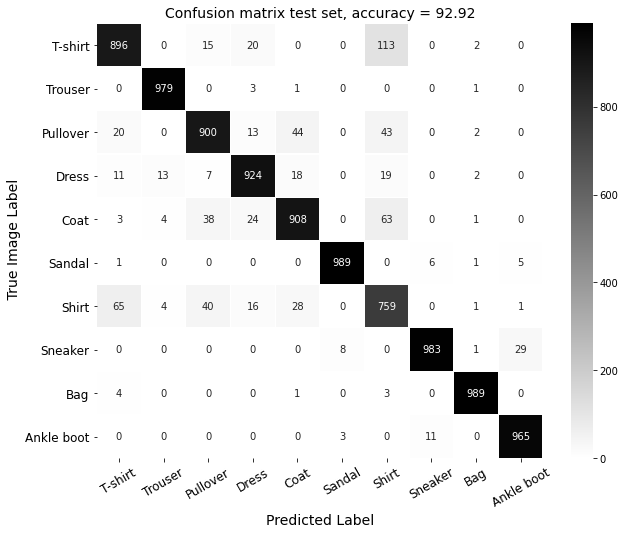

 
[[896   0  20  11   3   1  65   0   4   0]
 [  0 979   0  13   4   0   4   0   0   0]
 [ 15   0 900   7  38   0  40   0   0   0]
 [ 20   3  13 924  24   0  16   0   0   0]
 [  0   1  44  18 908   0  28   0   1   0]
 [  0   0   0   0   0 989   0   8   0   3]
 [113   0  43  19  63   0 759   0   3   0]
 [  0   0   0   0   0   6   0 983   0  11]
 [  2   1   2   2   1   1   1   1 989   0]
 [  0   0   0   0   0   5   1  29   0 965]]
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

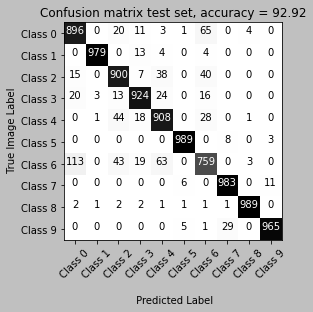

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.90      0.89      1000
           3       0.93      0.92      0.93      1000
           4       0.87      0.91      0.89      1000
           5       0.99      0.99      0.99      1000
           6       0.83      0.76      0.79      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.96      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [1]:
##################################################Cell for plotting confusion matrix from pre trained model.###################################
# Just set the PATH variable below to the trained model path and plot_CM_from_pretrained = True
import numpy as np
import pandas as pd

import torch

from torch import nn
from torch.utils.data import DataLoader

from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Conv2d

from torchvision import transforms
from torchvision import datasets

# These modules are which I've used for results visulaization.
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time

# This is just for interfacing the training progress.
from tqdm.autonotebook import tqdm
from google.colab import files

plot_CM_from_pretrained = True
# plot_CM_from_pretrained = False

PATH = "/content/Best_model"
dropout_flag = True
layers = 3



def function_plot_CM_from_pretrained():
  trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
  path_data = "/content"
  test_dataset = datasets.FashionMNIST(root=path_data, train=False, transform=trans, download=True)
  test_batch_size = 50
  test_loader = DataLoader(dataset=test_dataset, batch_size = test_batch_size, shuffle=False)
  print("Test Loader", len(test_loader))

  if torch.cuda.is_available():
      device_available = torch.device("cuda")  
  else: 
      device_available = torch.device("cpu")
  print(device_available)

  model = network(dropout_flag,layers)
  # Changing device to GPU if available.
  model = model.to(device_available)


  model.load_state_dict(torch.load(PATH))


  flag_wandb_log_status = False
  b_s = test_loader.batch_size
  length_loader = len(test_loader)
  prediction_dataset, correct_label, test_accuracy = prediction(test_loader, model, wandb_log_status = flag_wandb_log_status )
  if(flag_wandb_log_status == True):
    run_object.finish()


  length_prediction = b_s*length_loader
  prediction_dataset = np.array(prediction_dataset)
  prediction_dataset.resize([1,length_prediction])
  prediction_dataset.squeeze()
  prediction_dataset = prediction_dataset.tolist()
  prediction_dataset = prediction_dataset[0]


  correct_label = np.array(correct_label)
  correct_label.resize([1,length_prediction])
  correct_label.squeeze()
  correct_label = correct_label.tolist()
  correct_label = correct_label[0]

  c_matrix = (confusion_matrix(correct_label, prediction_dataset,labels= [0,1,2,3,4,5,6,7,8,9]))

  classes = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

  CM_title = "Confusion matrix test set, accuracy = " + str(test_accuracy)
  ConfMat = np.transpose(c_matrix)

  df_cm = pd.DataFrame(ConfMat)
  df_cm.columns = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
  df_cm.rename(index={0:"T-shirt", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}, inplace=True)
  print(df_cm)


  plt.figure(figsize = (10,8))

  font = {'size': 14}
  font_axis = {'size': 12}
  ax = sns.heatmap(df_cm, annot=True, fmt = "d", linewidths=.2, cmap = "gray_r")
  ax.set_xticklabels(classes,rotation=30,fontdict=font_axis)
  ax.set_yticklabels(classes,rotation=0,fontdict=font_axis)
  ax.set_title (CM_title,fontsize=14)
  ax.set_ylabel(' True Image Label', fontdict=font)
  ax.set_xlabel('Predicted Label', fontdict=font)
  plt.show()

  print(" ")
  print(c_matrix)
  print(" ")
  classes = ["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9"]
  confusion_matrix_plot(c_matrix, classes , title= CM_title, download_plots = False)
  print(classification_report(correct_label, prediction_dataset))

class network(nn.Module):
  def __init__(self,dropout_flag,layers):
    super(network, self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
    if(layers==2):
      self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2))
    elif(layers==3):
      self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2))
      self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),nn.ReLU())
    if(dropout_flag == True):
      self.drop_out = nn.Dropout(p=0.6)
    if(layers==2):
      self.fc1 = nn.Linear(7 * 7 * 64, 1000)
    elif(layers==3):
      self.fc1 = nn.Linear(7 * 7 * 128, 1000)
    else:
      self.fc1 = nn.Linear(14 * 14 * 32, 1000)
    self.fc2 = nn.Linear(1000, 10)
  def forward(self, x):
    x = self.layer1(x)
    if(layers==2):
      x = self.layer2(x)
    elif(layers==3):
      x = self.layer2(x)
      x = self.layer3(x)
    x = x.reshape(x.size(0), -1)
    if(dropout_flag == True):
      x = self.drop_out(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

def calc_accuracy(prediction_tensor, true_val_tensor):
  # This function is just to calculate the accuracy given the prediction and the true value of a batch of data.
  prediction_tensor = torch.log_softmax(prediction_tensor, dim = 1)
  _, max_idx = torch.max(prediction_tensor, dim = 1)

  true_val = true_val_tensor.tolist()
  predicted_val = max_idx.cpu().numpy()

  correct_count = 0
  for i in range(len(true_val)):
      
      if(predicted_val[i]==true_val[i]):
          correct_count += 1

  accuracy = (correct_count / len(true_val))*100 
  return accuracy
  


def confusion_matrix_plot(c_matrix, classes, title = "Confusion Matrix", bg_color = "silver", name_run_wandb = "random_run"):
  # This function if for plotting the confusion matrix.
      
  c_map=plt.cm.Greys
  plt.imshow(c_matrix, interpolation='nearest', cmap=c_map)

  plt.gcf().set_facecolor(bg_color)
  plt.title(title)

  axes = np.arange(len(classes))

  plt.xticks(axes, classes, rotation=45)
  plt.yticks(axes, classes)

  plt.ylabel(' True Image Label')
  plt.xlabel('\n Predicted Label')

  thresh = c_matrix.max() / 2.

  for i in range((c_matrix.shape[0])):
      for j in range((c_matrix.shape[1])):
          if c_matrix[i, j] > thresh:
              text_color = "white"  
          else:
              text_color = "black"
          plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color = text_color)
  
  CM_name_run = "CM_"+ name_run_wandb + ".png"
  plt.savefig(CM_name_run, bbox_inches="tight")
  files.download(CM_name_run)
  plt.show()

def prediction(test_dataloader, model,wandb_log_status = True):
  # This function is for predicting with help of the trained model.
  correct_label = []
  if torch.cuda.is_available():
    device_available = torch.device("cuda")  
  else: 
      device_available = torch.device("cpu")
  print(device_available)
  prediction_dataset = []
  with torch.no_grad():
    model.eval()
    test_accuracy = 0
    for i,(test_input,label) in enumerate(test_dataloader):
      test_input = test_input.to(device_available)
      label = label.to(device_available)
      output = model(test_input)
      accuracy = calc_accuracy(output,label)
      test_accuracy += accuracy
      output = torch.log_softmax(output, dim = 1)
      _, max_idx = torch.max(output, dim = 1)
      prediction_dataset.append(max_idx.cpu().numpy())
      correct_label.append(label.tolist())
          
  prediction_dataset = [pred.squeeze().tolist() for pred in prediction_dataset]
  # print(prediction_dataset)
  # print(correct_label)
  print("Accuracy: ",  (test_accuracy/len(test_dataloader)))
  if(wandb_log_status == True):
      wandb.log({"Test Accuracy": (test_accuracy/len(test_dataloader))})
  return prediction_dataset, correct_label, (test_accuracy/len(test_dataloader))

if plot_CM_from_pretrained == True:
  function_plot_CM_from_pretrained()